In [ ]:
import pandas as pd
import numpy as np
import glob
import os
import tensorflow as tf
from tensorflow.keras import layers, models
from google.colab import drive
import matplotlib.pyplot as plt
import math 
from IPython.display import Image
import cv2

# REQUIRES: Dataframe has an even number of cols, and column of interest is at every even column
# EFFECT: Drops all odd columns in a dataframe
def drop_odd_cols(dataframe):
  df = dataframe
  col_drop_list = []
  for i,col in enumerate(df.columns): 
    if(i % 2 == 0):
      col_drop_list.append(col)
  df = df.drop(col_drop_list,axis = 1)
  return df

def drop_first_col(dataframe):
  dataframe.pop(dataframe.columns[0])

#REQUIRES: Fraction is between 0-1 inclusive, elements in array are np_arrays
#EFFECT: Splits an array of np_arrays into 2 parts depending on value of fraction, e.g. fraction = 0.3 means arr1 is 70% & arr2 is 30% of np_array
def split_array(fraction, array):
  arr1 = [] #longer array 
  arr2 = []
  for i in range(len(array)):
    length = len(array[i])
    num_split = round(length * fraction)
    #array_split returns an array containing 3 elements [[null],[small np],[big np]]
    split = np.array_split(array[i], [0,num_split])
    arr1.append(split[2])
    arr2.append(split[1])
  return arr1, arr2

# REQUIRES: Folder path must be 1 directories above .xlsx files ({INPUT_PATH} -- > xlsx files)
# EFFECT: Reads all xlsx files in a folder and returns a 3D numpy array (batch_size, x,y) with data stacked along new axis (axis = 0)
def excel_reader(folder_path, drop_alternate = False, drop_first = False): 
    files = glob.glob(folder_path + "/*.xlsx")
    df_list = []
    for file in files:
        df = pd.read_excel(file)
        if drop_alternate:
          df = drop_odd_cols(df)
        if drop_first:
          drop_first_col(df)
        df_list.append(df)
    np_array = np.array(list(map(lambda x: x.to_numpy(), df_list)))
    np_array = np_array.reshape((len(df_list), len(df.axes[0]), len(df.axes[1])))
    return np_array

# EFFECT: Returns list of non-hidden folders & files present in a directory 
def listdir_non_hidden(folder_path): 
    folders = []
    for folder in os.listdir(folder_path):
        if not folder.startswith('.'):
            folders.append(folder)
    folders.sort()
    return folders

# REQUIRES: x,y,z be not empty
# EEFECT: generate model structure based on input shape of x,y,z
def create_model(choices, x,y,z):
  model = tf.keras.Sequential([
      layers.Conv2D(32, (3, 3), padding = "SAME", activation='relu', input_shape=(x,y,z)),
      layers.AveragePooling2D((2, 2), strides = (2,1)),
      layers.Conv2D(64, (3, 3), padding = "SAME", activation='relu'),
      layers.MaxPooling2D((2, 2), strides = (2,1)),
      layers.Conv2D(64, (3, 3), padding = "SAME", activation='relu'),
      layers.MaxPooling2D((2, 2), strides = (2,1)),
      layers.Conv2D(64, (3, 3), padding = "SAME", activation='relu'),
      layers.MaxPooling2D((2, 2), strides = (2,1)),
      layers.Flatten(),
      layers.Dropout(0.05),
      layers.Dense(50, activation = 'relu'),
      layers.Dense(50, activation = 'relu'),
      layers.Dense(len(choices))])

  model.compile(optimizer='adam',
                loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                metrics=['accuracy'])
      
  return model

def create_probability_model(model):
  probability_model = tf.keras.Sequential([model, 
                                         tf.keras.layers.Softmax()])
  return probability_model

# REQUIRES: Model weights in folder must match current model architecture
# EFFECT: Load a model from its saved weights
def load_model(path,x,y,z,choices):
  model = create_model(choices,x,y,z)
  model.load_weights(path)
  return model

# REQUIRES: - Maximum and minimum values are more than and less than 0 respectively 
#           - Folder path must be 2 directories above .xlsx files ({INPUT_PATH} -- > categories -- > xlsx files)
#           - fraction must be 0-1 inclusive
# EFFECT: Summarizes data of xslx files in a folder by returning four items: 
#         1. (1-fraction) of array whose elements are numpy datas corresponding to categories (e.g. [np1,np2,np3] )
#         2. remaining fraction amount of array in (3)
#         3. maximum value
#         4. minimum value
#         5. folder categories
def summarize(path, drop_alternate = False, drop_first = False):
  folders = listdir_non_hidden(path)
  max_val = 0
  min_val = 0
  datas = []
  for folder in folders:
    data = excel_reader(path + folder, drop_alternate = drop_alternate, drop_first = drop_first)
    current_max = data.max()
    current_min = data.min()
    if(max_val < current_max):
      max_val = current_max
    if(min_val > current_min):
      min_val = current_min
    datas.append(data)
  return datas, max_val, min_val, folders

def normalize(data,min_val,max_val):
  return((data - min_val) / (max_val - min_val))

# REQUIRES: Index >= 0, predictions is a 2D array and >= 3 along axis = 0, and choices reflect number of output nodes for model & are accurate in name
# EFFECT: Prints top 3 predictions for a given data with their respective probabilities
def predict_top_three(index, predictions, choices):
  prediction = []
  for i in range(len(predictions[index])):
    prediction.append(predictions[index][i])
  prediction = np.asarray(prediction)
  ranks = []
  for i in range(3):
    current_index = np.argmax(prediction)
    ranks.append(current_index)
    prediction[current_index] = 0
  print("The top three predictions are:")
  print("1.", choices[ranks[0]], "with probability of", predictions[index][ranks[0]])
  print("2.", choices[ranks[1]], "with probability of", predictions[index][ranks[1]])
  print("3.", choices[ranks[2]], "with probability of", predictions[index][ranks[2]])
  print()
  return

# REQUIRES: start_index, num_terms > 0, predictions is a 2D array and >= 3 along axis = 0, and choices reflect number of output nodes for model
# EFFECT: Prints top prediction for a given range (start-end)
def predict_top_three_multiple(start_index,num_terms, predictions,choices):
  range_predictions = predictions[start_index:start_index + num_terms]
  for i in range(num_terms):
    print("Data index (", i + start_index, ")")
    predict_top_three(i,range_predictions,choices)
  return

# REQUIRES: Index >= 0, data is a 4D array, predictions is a 2D array, choices reflect number of nodes of output, category is 1D array containing names of experimental categories, data is normalized
# EFFECT: Display a summary of a specific experimental data using a bar graph
def display_predictions(index, data, predictions, choices, category, category_index, min_val, max_val): 
    fig, ax = plt.subplots(1,2, gridspec_kw={'width_ratios': [1, 3]}, figsize=(20,10))
    # first subplot
    im = ax[0].imshow(data[index,:,:,0], aspect = 'auto', cmap = 'bwr', vmin = 0, vmax = 1)
    ax[0].set_xticks([])
    ax[0].set_yticks([])
    #ax[0].set_title(f"Data from category: {category[category_index[index]]}", size = 20)
    range_of_vals = np.round_(np.linspace(min_val, max_val, 6),6)
    normalized = np.linspace(0,1,6)
    cbar = plt.colorbar(im, ax=ax[0], ticks = normalized)
    cbar.ax.set_yticklabels(range_of_vals)
    # second subplot 
    thisplot = ax[1].bar(range(len(choices)), predictions[index], color="#FFCCCB")
    ax[1].set_xticks(range(len(choices)))
    ax[1].set_yticks([])
    ax[1].set_ylim([0,1])
    predicted_label = np.argmax(predictions[index])
    thisplot[predicted_label].set_color('#90EE90')
    ax[1].set_title(f"Predicted Category: {choices[predicted_label]} ({predicted_label} on graph)", size = 20)
    # to label each bar with percentage on top   
    for i, p in enumerate(predictions[index]):
      ax[1].text(i - 0.05, p + 0.01, str(round(p*100,2)) + '%', color='blue', size = 8)

def display_figure(num_rows, num_cols, data, category, category_index, min_val, max_val, same_data_same_row = False):
  fig, ax = plt.subplots(num_rows, num_cols, figsize=(25,70))
  if same_data_same_row:
    for row in range(num_rows):
      for col in range(num_cols):
        im = ax[row,col].imshow(data[row*num_cols + col,:,:,0], aspect = 'auto', cmap = 'bwr', vmin = 0, vmax = 1)
        ax[row,col].set_xticks([])
        ax[row,col].set_yticks([])
        ax[row,col].set_title(f"Category: {category[category_index[row*num_cols + col]]}\n", size = 15)
        range_of_vals = np.round_(np.linspace(min_val, max_val, 6),6)
        normalized = np.linspace(0,1,6)
        cbar = plt.colorbar(im, ax=ax[row,col], ticks = normalized)
        cbar.ax.set_yticklabels(range_of_vals)
  else:
    for col in range(num_cols):
      for row in range(num_rows):
        im = ax[row,col].imshow(data[col*num_rows + row,:,:,0], aspect = 'auto', cmap = 'bwr', vmin = 0, vmax = 1)
        ax[row,col].set_xticks([])
        ax[row,col].set_yticks([])
        ax[row,col].set_title(f"Category: {category[category_index[col*num_rows + row]]}\n", size = 15)
        range_of_vals = np.round_(np.linspace(min_val, max_val, 6),6)
        normalized = np.linspace(0,1,6)
        cbar = plt.colorbar(im, ax=ax[row,col], ticks = normalized)
        cbar.ax.set_yticklabels(range_of_vals)

def display_single_figure(path, min_val, max_val):
  df = pd.read_excel(path)
  df.pop(df.columns[0])
  data = normalize(df.to_numpy(), min_val, max_val)
  plt.figure(figsize=(4,10))
  plt.imshow(data, aspect = 'auto', cmap = 'bwr', vmin = 0, vmax = 1)
  plt.xticks([])
  plt.yticks([])
  normalized = np.linspace(0,1,6)
  cbar = plt.colorbar(ticks = normalized)
  range_of_vals = np.round_(np.linspace(min_val, max_val, 6),6)
  cbar.ax.set_yticklabels(range_of_vals)
  plt.show()

        
drive.mount('/content/drive/')
%cd "/content/drive/My Drive/Maldonado Lab/"


Mounted at /content/drive/
/content/drive/My Drive/Maldonado Lab


In [ ]:
# paths
trn_data_path =  "matrix-data-corrected/"
exp_data_path =  "exp-data-matrix/"
# fraction for validation split
split_percent = 0.3

# gather training datas & make labels
trn_datas, max_trn_val, min_trn_val, trn_categories = summarize(trn_data_path, drop_alternate = False, drop_first = True)
trn_labels = []
for i in range(len(trn_datas)):
  temp = []
  for j in range(len(trn_datas[i])):
    temp.append(i)
  trn_labels.append(temp)

# split training data and labels and join them along vertical and horizontal axis respectively
train_data, validation_data = split_array(split_percent,trn_datas)
train_labels, validation_labels = split_array(split_percent,trn_labels)

train_data = np.vstack(train_data)
validation_data = np.vstack(validation_data)

train_labels = np.hstack(train_labels)
validation_labels = np.hstack(validation_labels)

# gather experimental data & make categories
exp_datas, max_exp_val, min_exp_val, exp_categories = summarize(exp_data_path, drop_alternate = False, drop_first = True)
experimental_data = np.vstack(exp_datas)
exp_categories_index = []
for i in range(len(exp_datas)):
  for j in range(len(exp_datas[i])):
    exp_categories_index.append(i)
exp_categories_index = np.asarray(exp_categories_index)

# normalize data (shift range from negative-positive values to 0-1 values)
max_val = max(max_trn_val,max_exp_val)
min_val = min(min_trn_val,min_exp_val)
train_data = normalize(train_data,min_val,max_val)
validation_data = normalize(validation_data,min_val,max_val)
experimental_data = normalize(experimental_data,min_val,max_val)

# write max and min value to txt file for future data checking/normalization
#os.remove('max-min.txt')
np.savetxt('max-min-corrected.txt',[max_val,min_val])

# add dimensionality along last axis (3D --> 4D) since CNN requires 4D input
train_data = np.expand_dims(train_data, axis = len(train_data.shape))
validation_data = np.expand_dims(validation_data, axis = len(validation_data.shape))
experimental_data = np.expand_dims(experimental_data, axis = len(experimental_data.shape))

print("Dimensions of training data & labels:",train_data.shape,"&",train_labels.shape)
print("Dimensions of validation data & labels:",validation_data.shape,"&",validation_labels.shape)
print("Dimensions of experimental data:",experimental_data.shape)
print("Training categories:", trn_categories)
print("Experimental categories", exp_categories)

# 15mins to run

Dimensions of training data & labels: (4900, 426, 14, 1) & (4900,)
Dimensions of validation data & labels: (2100, 426, 14, 1) & (2100,)
Dimensions of experimental data: (1, 426, 14, 1)
Training categories: ['Ecb_E0=-0.1 reduced', 'Ecb_E0=-0.13 reduced', 'Ecb_E0=-0.16 reduced', 'Ecb_E0=-0.19 reduced', 'Ecb_E0=-0.22 reduced', 'Ecb_E0=-0.25 reduced', 'Ecb_E0=-0.28 reduced', 'Ecb_E0=-0.31 reduced', 'Ecb_E0=-0.34 reduced', 'Ecb_E0=-0.37 reduced', 'Ecb_E0=-0.4 reduced', 'Ecb_E0=-0.43 reduced', 'Ecb_E0=-0.46 reduced', 'Ecb_E0=-0.49 reduced']
Experimental categories ['category1']


In [ ]:
tf.keras.backend.clear_session()

In [ ]:
# make instance of model
x,y,z = train_data.shape[1], train_data.shape[2], train_data.shape[3]
print("Model input dimensions: NONE,", x, ',', y, ',', z)
model = create_model(trn_categories,x,y,z)
model.summary()

Model input dimensions: NONE, 426 , 14 , 1
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 426, 14, 32)       320       
                                                                 
 average_pooling2d (AverageP  (None, 213, 13, 32)      0         
 ooling2D)                                                       
                                                                 
 conv2d_1 (Conv2D)           (None, 213, 13, 64)       18496     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 106, 12, 64)      0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 106, 12, 64)       36928     
                                                                 
 max_pooling2

In [ ]:
model.fit(train_data, train_labels, shuffle = True, epochs = 12, validation_data = (validation_data,validation_labels))
# TO implement: early stopping callback

# avg 154 seconds per epoch, trained on 15 epochs
p_model = create_probability_model(model)

Epoch 1/12
154/154 [==============================] - 159s 1s/step - loss: 1.9693 - accuracy: 0.2406 - val_loss: 1.0691 - val_accuracy: 0.5176
Epoch 2/12
154/154 [==============================] - 154s 1s/step - loss: 0.9439 - accuracy: 0.5906 - val_loss: 1.0156 - val_accuracy: 0.5271
Epoch 3/12
154/154 [==============================] - 148s 960ms/step - loss: 0.8170 - accuracy: 0.6508 - val_loss: 0.6467 - val_accuracy: 0.7162
Epoch 4/12
154/154 [==============================] - 154s 995ms/step - loss: 0.6784 - accuracy: 0.7102 - val_loss: 0.5584 - val_accuracy: 0.7819
Epoch 5/12
154/154 [==============================] - 151s 979ms/step - loss: 0.5701 - accuracy: 0.7592 - val_loss: 0.4776 - val_accuracy: 0.7990
Epoch 6/12
154/154 [==============================] - 145s 939ms/step - loss: 0.4906 - accuracy: 0.7996 - val_loss: 0.4317 - val_accuracy: 0.8229
Epoch 7/12
154/154 [==============================] - 157s 1s/step - loss: 0.4180 - accuracy: 0.8229 - val_loss: 0.3470 - val_accu

In [ ]:
## if validation is good (>85%) --> save weights in path below
save_to_path = "weights/matrix-data/corrected-attempt1/"
model.save_weights(save_to_path)

In [ ]:
tf.keras.backend.clear_session()

In [ ]:
# RUN THIS IF: model was previously saved and would only like to predict results on new experimental data
trn_data_path = "matrix-data-corrected/"
exp_data_path =  "exp-data-matrix/" #"exp-data-matrix/"
saved_path_weights = "weights/matrix-data/corrected-attempt1/"
min_max_file = "max-min-corrected.txt"
#small_trn_path = "small-sample-small-w-noise/"

# load experimental data & model
exp_datas, max_exp_val, min_exp_val, exp_categories = summarize(exp_data_path, drop_alternate = False, drop_first = True)
exp_categories_index = []
for i in range(len(exp_datas)):
  for j in range(len(exp_datas[i])):
    exp_categories_index.append(i)
exp_categories_index = np.asarray(exp_categories_index)
# PITFALL: - ensure max_exp_val and min_exp_val of new batch is less than saved max and min values
#          - else, predictions could be inaccurate
experimental_data = np.vstack(exp_datas)
# load min and max data from docs
f = open(min_max_file, 'r')
nums = f.readlines()
nums = [eval(i) for i in nums]
max_val = nums[0]
min_val = nums[1]
if min_exp_val < min_val:
  print("Warning: new minimum value detected from experimental data")
if max_exp_val > max_val:
  print("Warning: new maximum value detected from experimental data")
'''
# load small sample data for visual check
small_trn_datas, max_small_trn_val, min_small_trn_val, small_trn_categories = summarize(small_trn_path, drop_alternate = False, drop_first = True)
small_trn_categories_index = []
for i in range(len(small_trn_datas)):
  for j in range(len(small_trn_datas[i])):
    small_trn_categories_index.append(i)
small_trn_categories_index = np.asarray(small_trn_categories_index)
small_train_data = np.vstack(small_trn_datas)
small_train_data = normalize(small_train_data,min_val,max_val)
small_train_data = np.expand_dims(small_train_data, axis = len(small_train_data.shape))
'''
experimental_data = normalize(experimental_data,min_val,max_val)
experimental_data = np.expand_dims(experimental_data, axis = len(experimental_data.shape))
trn_categories = listdir_non_hidden(trn_data_path)
x,y,z = experimental_data.shape[1], experimental_data.shape[2], experimental_data.shape[3]
print("Model input dimensions: NONE,", x, ',', y, ',', z)
model = load_model(saved_path_weights,x,y,z,trn_categories)
#model = create_model(trn_categories,x,y,z)
p_model = create_probability_model(model)
print(model.summary())
print(p_model.summary())

Model input dimensions: NONE, 426 , 14 , 1
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 426, 14, 32)       320       
                                                                 
 average_pooling2d (AverageP  (None, 213, 13, 32)      0         
 ooling2D)                                                       
                                                                 
 conv2d_1 (Conv2D)           (None, 213, 13, 64)       18496     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 106, 12, 64)      0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 106, 12, 64)       36928     
                                                                 
 max_pooling2

In [ ]:
def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

# TESTING FUNCTIONS
def save_and_display_gradcam_2(img, heatmap, cam_path="cam.jpg", alpha=0.4):

    heatmap = cv2.resize(heatmap, dsize=(img.shape[1], img.shape[0]), 
                         interpolation=cv2.INTER_CUBIC)
    heatmap = tf.keras.preprocessing.image.img_to_array(heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = heatmap * alpha + img
    superimposed_img = tf.keras.preprocessing.image.array_to_img(superimposed_img)

    # Display Grad CAM
    plt.imshow(superimposed_img, aspect = 'auto')

def save_and_display_gradcam(img, heatmap, cam_path="cam.jpg", alpha=0.4):
    heatmap = np.uint8(255 * heatmap)

    # Use jet colormap to colorize heatmap
    cmap = plt.cm.get_cmap("binary")

    # Use RGB values of the colormap
    jet_colors = cmap(np.arange(256))[:,:1]
    jet_heatmap = np.squeeze(jet_colors[heatmap])

    # Create an image with RGB colorized heatmap
    jet_heatmap = cv2.resize(jet_heatmap, dsize=(img.shape[1], img.shape[0]), 
                         interpolation=cv2.INTER_CUBIC)
    jet_heatmap = tf.keras.preprocessing.image.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * alpha + img
    test =  tf.keras.preprocessing.image.array_to_img(jet_heatmap)
    superimposed_img = tf.keras.preprocessing.image.array_to_img(superimposed_img)

    # Display Grad CAM
    plt.imshow(superimposed_img, aspect = 'auto')
    plt.colorbar()
    


In [ ]:
last_conv_layer = "max_pooling2d_2"
preds = model.predict(experimental_data)

1/1 [==============================] - 0s 332ms/step


<ipython-input-4-0bbf001e67a8>:52: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap("binary")


(256, 1)
(256, 1)
[[[0.38235073]
  [0.32587862]
  [0.30276589]
  ...
  [0.38897638]
  [0.36815566]
  [0.37468501]]

 [[0.38323672]
  [0.32780468]
  [0.30411413]
  ...
  [0.38911121]
  [0.36838679]
  [0.37491613]]

 [[0.38374327]
  [0.32934553]
  [0.30584758]
  ...
  [0.38928455]
  [0.36863718]
  [0.37505096]]

 ...

 [[0.16794161]
  [0.18142404]
  [0.20434417]
  ...
  [0.3033437 ]
  [0.30681061]
  [0.31008492]]

 [[0.17179373]
  [0.1833501 ]
  [0.20607762]
  ...
  [0.30372892]
  [0.30700322]
  [0.31047013]]

 [[0.17757192]
  [0.18720222]
  [0.20800368]
  ...
  [0.30430674]
  [0.30738843]
  [0.31085534]]]
[[[0.69005014]
  [0.62598637]
  [0.59601782]
  ...
  [0.71383663]
  [0.69185063]
  [0.69892194]]

 [[0.69138835]
  [0.62840646]
  [0.59789538]
  ...
  [0.71433188]
  [0.69234328]
  [0.69936097]]

 [[0.69210531]
  [0.63017718]
  [0.59987512]
  ...
  [0.71467295]
  [0.69271535]
  [0.6995925 ]]

 ...

 [[0.2631598 ]
  [0.27207471]
  [0.2882237 ]
  ...
  [0.61606505]
  [0.61848321]
  [0.62

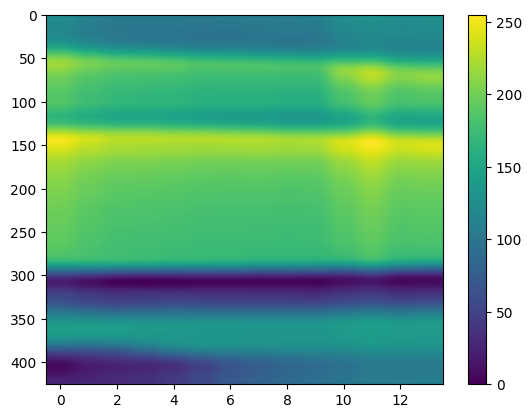

In [ ]:
# change to view different heatmaps
i = 0

heatmap = make_gradcam_heatmap(np.expand_dims(experimental_data[0], axis = 0), model, last_conv_layer)
#note: heatmap size is dependent on the last conv layer (53,1). Kind of retarded layer since we simplify all the values into 1 pixel. This is probably a bad idea. 
save_and_display_gradcam(experimental_data[i], heatmap)

1/1 [==============================] - 0s 109ms/step


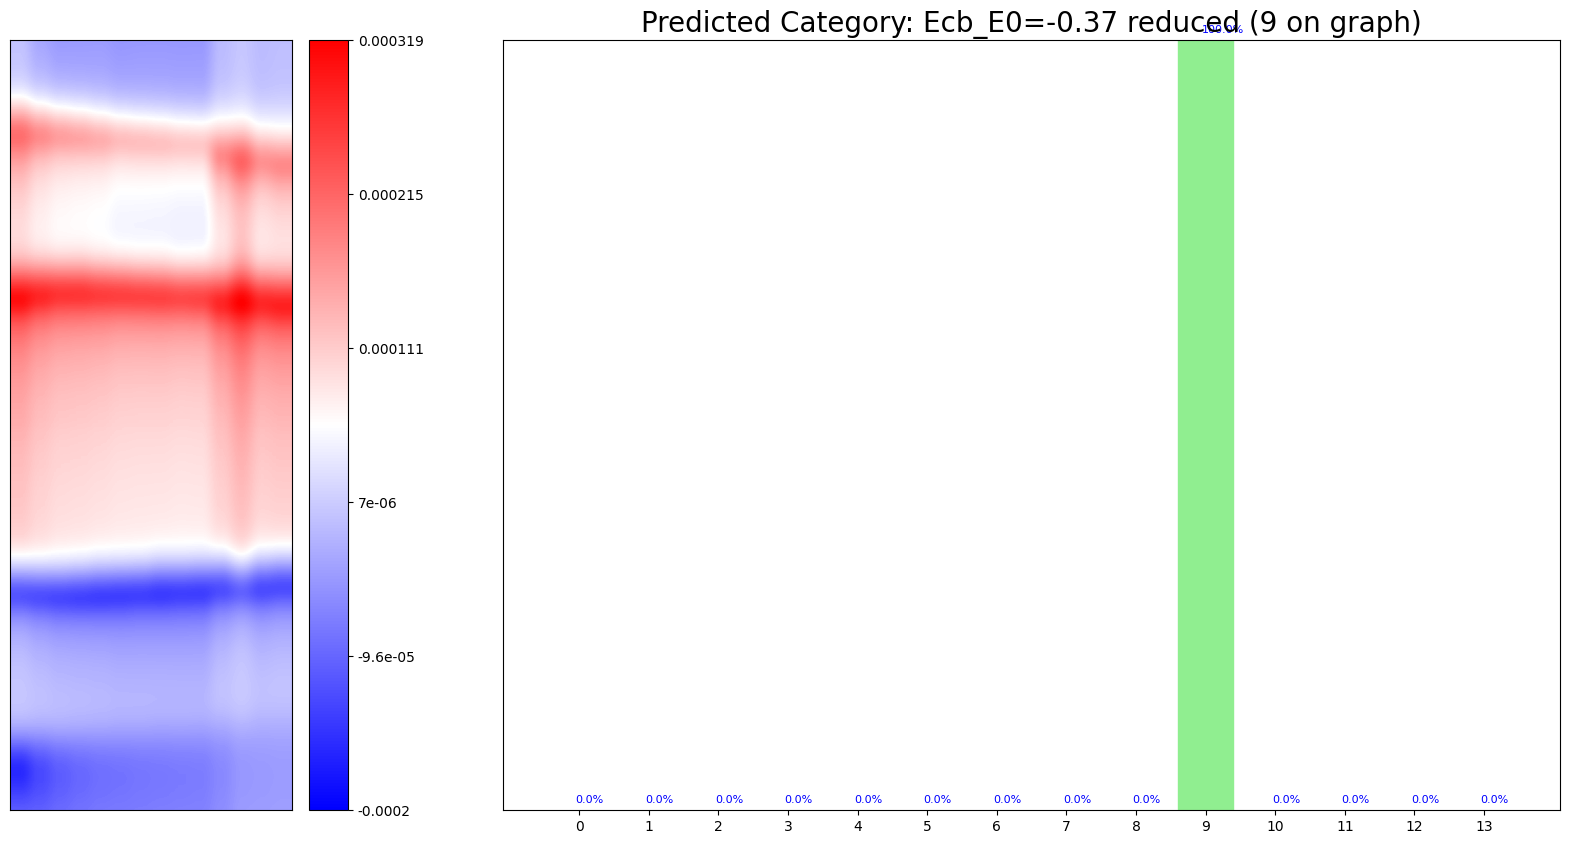

In [ ]:
# TO DO: input i value of data you would like to see and j value of method of displaying
i = 0
j = 2
predictions = p_model.predict(experimental_data) #validation_data
if(j == 0):
  predict_top_three(i,predictions,trn_categories)
elif(j == 1):
  predict_top_three_multiple(i,9,predictions,trn_categories)
elif(j == 2):
  #swaps made: experimental_data -> validation_data, exp_categories-> trn_categories
  display_predictions(i,experimental_data,predictions,trn_categories,exp_categories, exp_categories_index, min_val, max_val)